# Mathematical Underpinnings - Lab 10

In [1]:
%%capture
! wget https://raw.githubusercontent.com/MalgosiaL/MatUnder/main/labs/prostate.data
! wget https://raw.githubusercontent.com/MalgosiaL/MatUnder/main/labs/SRBCT_X.txt
! wget https://raw.githubusercontent.com/MalgosiaL/MatUnder/main/labs/SRBCT_Y.txt

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
from sklearn.preprocessing import scale

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [71]:
df = pd.read_csv('prostate.data', sep="\t", index_col=0)

In [72]:
columns = df.iloc[:, 0:8].columns.tolist()

In [73]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [74]:
X = scale(X)
Y = scale(Y)

### a)

In [75]:
# fit
model_lars = Lars(fit_intercept=False).fit(X, Y)

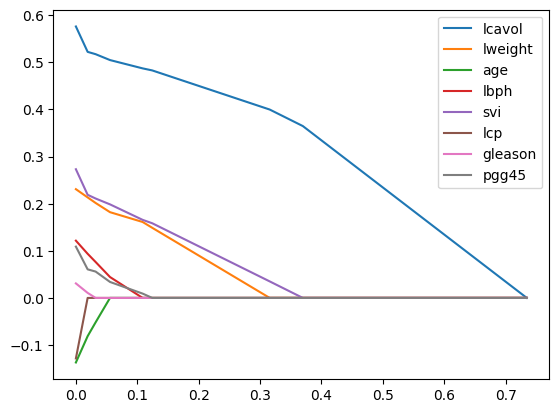

In [76]:
# plot
plt.plot(model_lars.alphas_, model_lars.coef_path_.T)
plt.legend(columns)
plt.show()

Order in which the variables are included in the model:

1. lcavol
2. svi
3. lweight
4. pgg45
5. lbph
6. age
7. gleason
8. lcp

### b)

In [77]:
model_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

### b1)

In [78]:
selected_variables = []

In [79]:
selected_variables.append(np.argmax(np.abs(np.corrcoef(X.T, Y)[-1,:8])))

In [80]:
selected_variables

[0]

### b2)

In [81]:
mod1 = LinearRegression(fit_intercept=False).fit(X[:, selected_variables], Y)

In [82]:
mod1.coef_

array([0.73446033])

### b3)

In [83]:
alphas = np.linspace(0, 1, 100)
y_hat = mod1.predict(X[:, selected_variables])
residuals = Y[:, None] - alphas[None, :] * y_hat[:, None]

In [99]:
res_corr = np.zeros((len(alphas), X.shape[1]))

for i, alpha in enumerate(alphas):
    for j in range(X.shape[1]):
        res_corr[i, j] = np.corrcoef(X[:, j], residuals[:, i])[0, 1]

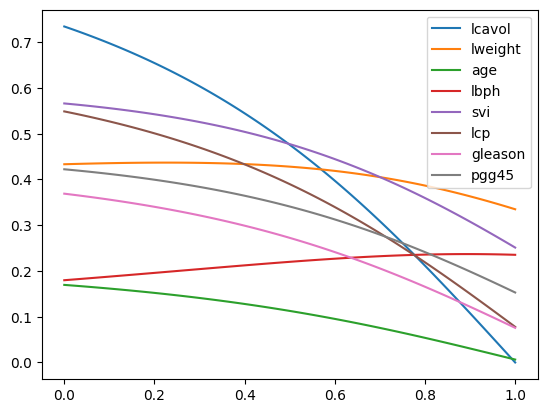

In [85]:
plt.plot(alphas, res_corr)
plt.legend(columns)
plt.show()

**Answer**: The blue line (lcavol variable)

### b4)

**Answer**: svi variable, $\alpha_{2}$ is approximately 0.5

In [86]:
res_corr[49, 0], res_corr[49, 4]

(0.47961521036518956, 0.478835954257157)

### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

In [87]:
alpha_list = np.linspace(0, 1, 100)
values = np.zeros((100, 8))
for j, alpha in enumerate(alpha_list):
    for i in range(8):
      values[j, i] = np.sqrt(np.var(Y)) * np.corrcoef(Y, X[:, i])[0][1] - np.sqrt(np.var(y_hat)) * alpha * np.corrcoef(y_hat, X[:, i])[0][1]

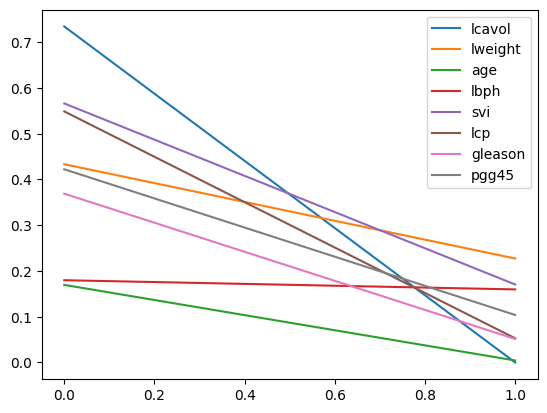

In [88]:
plt.plot(alpha_list, values)
plt.legend(columns)
plt.show()

In [89]:
new_var = np.argmin((np.nan_to_num(
    (np.sqrt(np.var(Y)) * np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.sqrt(np.var(Y))* np.corrcoef(X.T, Y)[:-1, -1]) /
    (np.sqrt(np.var(y_hat))* np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.sqrt(np.var(y_hat))* np.corrcoef(X.T, y_hat)[:-1, -1]),
    nan = 1)
))
new_var

<ipython-input-89-b8836b8c67b4>:2: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(np.var(Y)) * np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.sqrt(np.var(Y))* np.corrcoef(X.T, Y)[:-1, -1]) /


4

In [90]:
a = np.sqrt(np.var(Y)) * np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.sqrt(np.var(Y)) * np.corrcoef(X.T, Y)[:-1,-1]
b = np.sqrt(np.var(y_hat)) * np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.sqrt(np.var(y_hat)) * np.corrcoef(X.T, y_hat)[:-1,-1]

alpha_2 = np.min(np.nan_to_num(a/b, nan = 1))
alpha_2

<ipython-input-90-87aae01d655c>:4: RuntimeWarning: invalid value encountered in divide
  alpha_2 = np.min(np.nan_to_num(a/b, nan = 1))


0.4967289013871957

### b6)

In [91]:
alpha_2_without_tilde = np.std(Y)* np.corrcoef(X[:, new_var], Y)[0, 1] - np.std(y_hat) * alpha_2 * np.corrcoef(X[:, new_var], y_hat)[0, 1]
alpha_2_without_tilde

0.3696326552610745

In [92]:
r_1_alpha_tilde_2 = Y - y_hat * alpha_2

In [93]:
selected_variables.append(new_var)
selected_variables

[0, 4]

### b7)

In [94]:
mod2 = LinearRegression(fit_intercept=False).fit(X[:, selected_variables], r_1_alpha_tilde_2)
mod2.coef_

array([0.24020136, 0.24020136])

### b8)

In [95]:
alphas = np.linspace(0, 1, 101)
y_hat = mod2.predict(X[:, selected_variables])
residuals = r_1_alpha_tilde_2[:, None] - alphas[None, :] * y_hat[:, None]

In [96]:
res_corr = np.zeros((len(alphas), X.shape[1]))

for i, alpha in enumerate(alphas):
    for j in range(X.shape[1]):
        res_corr[i, j] = np.corrcoef(X[:, j], residuals[:, i])[0, 1]

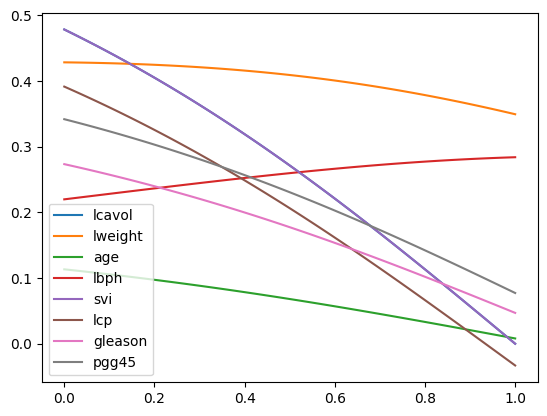

In [97]:
plt.plot(alphas, res_corr)
plt.legend(columns)
plt.show()

### b9)

**ANSWER**: Orange line, lweight variable, value approximately 0.15

### b10)

In [102]:
alpha_list = np.linspace(0, 1, 100)
values = np.zeros((100, 8))
for j, alpha in enumerate(alpha_list):
    for i in range(8):
      values[j, i] = np.sqrt(np.var(r_1_alpha_tilde_2)) * np.corrcoef(r_1_alpha_tilde_2, X[:, i])[0][1] - np.sqrt(np.var(y_hat)) * alpha * np.corrcoef(y_hat, X[:, i])[0][1]

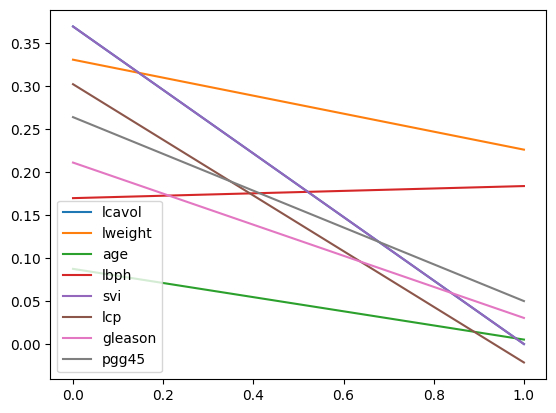

In [103]:
plt.plot(alpha_list, values)
plt.legend(columns)
plt.show()

### b11)

In [104]:
new_var = np.argmin((np.nan_to_num(
    (np.sqrt(np.var(r_1_alpha_tilde_2)) * np.corrcoef(X.T, r_1_alpha_tilde_2)[selected_variables[-1], -1] - np.sqrt(np.var(r_1_alpha_tilde_2))* np.corrcoef(X.T, r_1_alpha_tilde_2)[:-1, -1]) /
    (np.sqrt(np.var(y_hat))* np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.sqrt(np.var(y_hat))* np.corrcoef(X.T, y_hat)[:-1, -1]),
    nan = 1)
))
new_var

<ipython-input-104-e35c812ca510>:2: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(np.var(r_1_alpha_tilde_2)) * np.corrcoef(X.T, r_1_alpha_tilde_2)[selected_variables[-1], -1] - np.sqrt(np.var(r_1_alpha_tilde_2))* np.corrcoef(X.T, r_1_alpha_tilde_2)[:-1, -1]) /


1

In [105]:
a = np.sqrt(np.var(r_1_alpha_tilde_2)) * np.corrcoef(X.T, r_1_alpha_tilde_2)[selected_variables[-1], -1] - np.sqrt(np.var(r_1_alpha_tilde_2)) * np.corrcoef(X.T, r_1_alpha_tilde_2)[:-1,-1]
b = np.sqrt(np.var(y_hat)) * np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.sqrt(np.var(y_hat)) * np.corrcoef(X.T, y_hat)[:-1,-1]

alpha_3 = np.min(np.nan_to_num(a/b, nan = 1))
alpha_3

<ipython-input-105-cdcbe85e9c9d>:4: RuntimeWarning: invalid value encountered in divide
  alpha_3 = np.min(np.nan_to_num(a/b, nan = 1))


0.14590879649354713

### c)